# Spatial Attributes Analysis

In [1]:
import numpy as np
import requests
from datetime import date
import time
import math
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import seaborn as sns
import folium
import geopandas as gpd
import fiona
from shapely.geometry import Point
%matplotlib inline

# Load housing data from Boligsiden API

In [2]:
def log(response, logfile, output_path=os.getcwd()):
    """# Logging function to gather the log information"""
    # Open or create the csv file
    if os.path.isfile(logfile): #If the log file exists, open it and allow for changes     
        log = open(logfile,'a')
    else: #If the log file does not exist, create it and make headers for the log variables
        log = open(logfile,'w')
        header = ['timestamp','status_code','length','output_file']
        log.write(';'.join(header) + "\n") #Make the headers and jump to new line
        
    # Gather log information
    status_code = response.status_code #Status code from the request result
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())) #Local time
    length = len(response.text) #Length of the HTML-string
    
    # Open the log file and append the gathered log information
    with open(logfile,'a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path}' + "\n") #Append the information and jump to new line

In [3]:
year_from = 2000 # Determine start year
# municipality_codes = [101, 147] # codes for Copenhagen and Frederiksberg
# total_pages = [] # list to store pages

# base_url = 'https://api.boliga.dk/api/v2/sold/search/results'
# for i in range(0, len(municipality_codes)):
#     query_url = f'?propertyType=1,2,3,9&municipality={municipality_codes[i]}&salesDateMin={year_from}&salesDateMax=today&sort=date-d&page=1'
#     url1 = base_url + query_url
#     response = requests.get(url1, headers={'name':'Julius Løve fischer','email':'nbm205@alumni.ku.dk'}).json()
#     total_pages.append(response['meta']['totalPages'])

# print(response['meta'])

In [4]:
# query_urls = [] # list to contain query_urls for main data
# [[query_urls.append(f'?propertyType=1,2,3,9&municipality={municipality}&salesDateMin={year_from}&salesDateMax=today&sort=date-d&page={page_num}')\
#               for page_num in range(1, pages + 1)] for municipality, pages in zip(municipality_codes, total_pages)]

# query_urls_extra = [] # list to contain query_urls for extra housing information using Boliga BBR database
# [[query_urls_extra.append(f'?propertyType=1,2,3,9&municipality={municipality}&salesDateMin={year_from}&salesDateMax=today&sort=date-d&page={page_num}')\
#               for page_num in range(1, pages + 1)] for municipality, pages in zip(municipality_codes, total_pages)]

# logfile = 'log.csv'
# houses = pd.DataFrame()

# def scraper(base_url, query_urls):
#     for query_url in tqdm.tqdm(query_urls):
#         url = base_url + query_url
#         try:
#             response = requests.get(url, headers={'name':'Julius Løve fischer','email':'nbm205@alumni.ku.dk'})
#         except Exception as e:
#             print(url) #Print url
#             print(f'An error has occured: {e}') #Print error
#             houses.to_csv('houses.csv') #Save the dataframe as a csv file to retrieve at another time
#             continue #Continue to next iteration of the loop
        
#         if response.ok: #Check if the response carries any data
#             result_json = response.json() #If the response carries data, then convert it to json format
#         else: #If the response does not carry any data, then print the status_code and continue to next iteration of the loop
#             print(f'Status code: {response.status_code}')
#             continue
        
#         result_df = pd.DataFrame(result_json['results']) #Convert this iteration's json file to a dataframe
#         houses = pd.concat([houses,result_df], axis=0, ignore_index=True) #Append to the rest of the data
#         log(response, logfile)
#         time.sleep(0.5) #Sleep for 0.5 seconds
#     return houses

# houses = scraper(base_url, query_urls)
    
# # houses.to_csv('houses.csv', index=False)

## Clean and transform data

In [5]:
houses = pd.read_csv('houses.csv')
# vigtigt_url = 'https://api.boliga.dk/api/v2/bbrinfo/bbr?id=f08ba307-5131-485f-8a9c-a51b53511aa3'
# houses['floor'].astype('category').unique()

column_selection = ['address', 'zipCode', 'price', 'soldDate', 'propertyType',
            'saleType', 'sqmPrice', 'rooms', 'size', 'buildYear', 'guid', 'latitude',
            'longitude', 'municipalityCode', 'city']

houses = houses[column_selection].query("saleType == 'Alm. Salg'") # select relevant columns and sale types
houses['soldDate'] = pd.to_datetime(houses['soldDate'].astype(str)).dt.date
houses = houses.sort_values(by="soldDate", ascending = False) # Dataframe is not sorted by default as we have two query_lists
houses = houses.set_index('soldDate')

points = houses.apply(lambda row: Point(row['longitude'], row['latitude']), axis = 1) # create housing points
geo_houses = gpd.GeoDataFrame(houses, geometry = points, crs = 'EPSG:4326') 
geo_houses.to_crs(epsg=25832, inplace=True) # this epsg code uses meters as unit measure
geo_houses

,address,zipCode,price,propertyType,saleType,sqmPrice,rooms,size,buildYear,guid,latitude,longitude,municipalityCode,city,geometry
soldDate,,,,,,,,,,,,,,,
2022-07-27,"Gyldenlakvej 27, 1. tv",2300,2340000,3,Alm. Salg,41052.633,2.0,57,1938,F08BA307-5131-485F-8A9C-A51B53511AA3,55.645130,12.612886,101,København S,POINT (727333.431 6172505.034)
2022-07-27,"Gammel Kongevej 165A, 1",1850,5995000,3,Alm. Salg,66611.110,3.0,90,2000,5DDDA144-2D9E-413D-9CBE-468522500A68,55.677700,12.535549,147,Frederiksberg C,POINT (722284.632 6175876.454)
2022-07-27,"Rolfsvej 37, 2. th",2000,7887000,3,Alm. Salg,71054.055,4.0,111,1916,CF5A390D-4B0B-4F11-A79F-109E540864E0,55.683937,12.531795,147,Frederiksberg,POINT (722013.364 6176558.067)
2022-07-26,"Havneholmen 82, 2. th",1561,5200000,3,Alm. Salg,68421.055,2.0,76,2008,31C9CF15-56CD-4E0C-8324-5E9F34BFD78B,55.661070,12.564086,101,København V,POINT (724173.079 6174118.862)
2022-07-22,"Islands Brygge 24B, 4. tv",2300,7825000,3,Alm. Salg,74523.810,3.0,105,1910,95E09D1F-DCF2-4E5C-ABB4-FD3E753A7C3C,55.663128,12.571215,101,København S,POINT (724609.471 6174370.811)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-01-02,"Lykkesholms Allé 10, 2. th",1902,1850000,3,Alm. Salg,22289.156,4.0,83,1876,5E3FD65E-27A7-46DF-9893-03284D76C75B,55.676643,12.548173,147,Frederiksberg C,POINT (723083.970 6175799.454)
2000-01-02,"Lykkesholms Allé 10, 1",1902,1850000,3,Alm. Salg,14015.151,4.0,132,1876,3DF49D93-7B12-44BD-A75A-D6E61ED6972E,55.676643,12.548173,147,Frederiksberg C,POINT (723083.970 6175799.454)
2000-01-02,"Lykkesholms Allé 10, 2. tv",1902,1850000,3,Alm. Salg,108823.530,1.0,17,1876,1A503662-4E1B-4E37-A991-85E3F01789FC,55.676643,12.548173,147,Frederiksberg C,POINT (723083.970 6175799.454)


In [6]:
houses['saleType'].astype('category').unique()
# houses.count()
# houses['size'].isna().sum()
# houses.columns

['Alm. Salg']
Categories (1, object): ['Alm. Salg']

### Plotting using map from GitHub

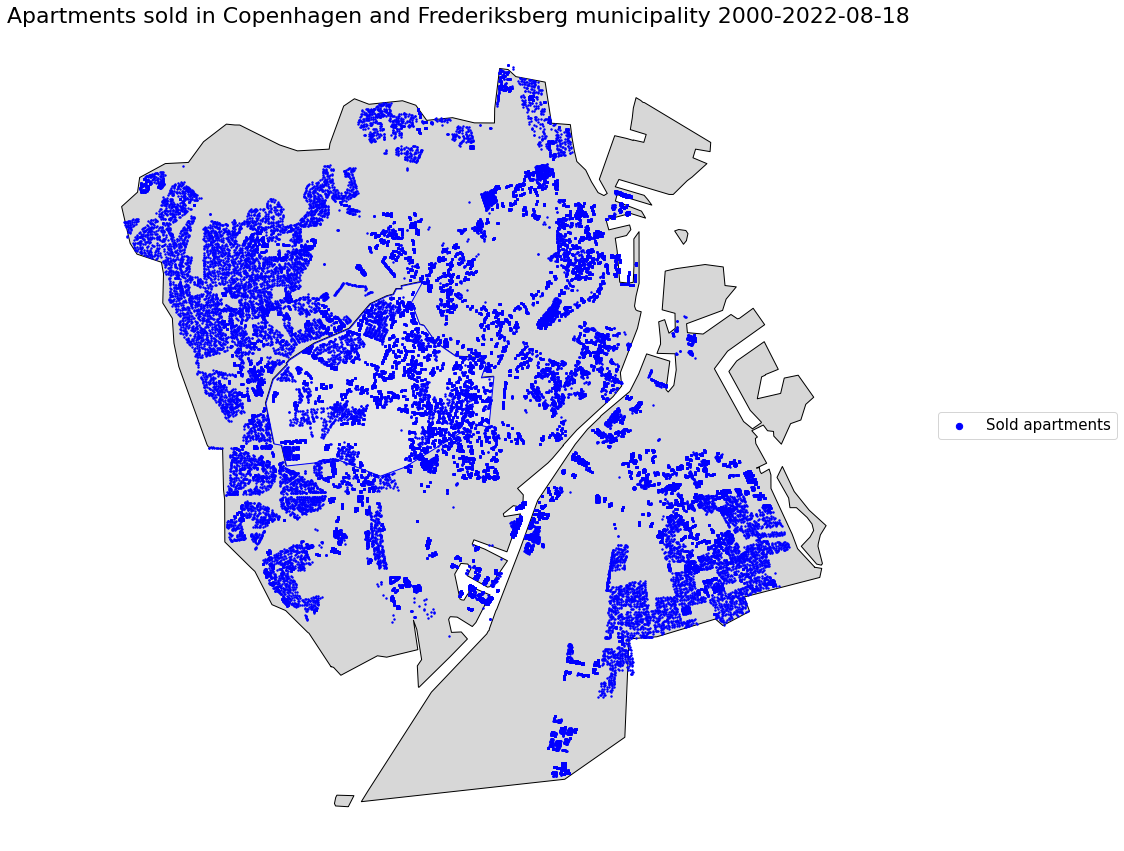

In [7]:
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"
kommuner = gpd.read_file(url)
kommuner.to_crs('epsg:25832', inplace=True) # this epsg code uses meters as unit measure
kommuner.columns = kommuner.columns.str.lower()
cph = kommuner[kommuner.komnavn.isin(['København'])].copy() # Store polygons for cph
frb = kommuner[kommuner.komnavn.isin(['Frederiksberg'])].copy() # Store polygons for frb


fig, ax = plt.subplots(figsize=(20, 15))

#cph municipality 
cph.plot(color='#d7d7d7',edgecolor='black', ax=ax, label = "CPH Municipality")

#frb municipality
frb.plot(color='#e5e5e5', edgecolor='blue',  ax=ax, label = "FRB Municipality")

#plot houseprices
geo_houses.plot(ax=ax, color = "blue", markersize=2,  label = "Sold apartments")

#narrow xlim
ax.set_xlim([716000, 730000]) # based on north eastern epsg: 25832
ax.set_axis_off()
ax.set_title(f'Apartments sold in Copenhagen and Frederiksberg municipality {year_from}-{date.today()}', fontsize=22)

#handle legend 
lgnd = fig.legend(loc=7, ncol=1, fontsize = 15)    
lgnd.legendHandles[0]._sizes = [40]


fig.subplots_adjust(right=0.95) 

## Plotting with OSM

In [8]:
import logging
from collections import defaultdict

import overpy
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

def ways2poly(ways):
    """
    Given an iterable of `ways`, combined them into one or more polygons.
    
    Args:
        ways: iterable of `overpy.Way` that form the desired polygon:w
        
    Return:
        polys, incomplete: `polys` is a list of list of  (long, lat) coords describing 
            valid (i.e. closed) polygons; `incomplete` is a list of list of (long, lat) 
            coords describing "incomplete polygons" (i.e. LineString)
    """
    w = set(ways)
    polys = []
    incomplete = []
    current = None
    while True:
        if not current:
            if len(w) > 0:
                current = w.pop().nodes
            else:
                break
        if current[0].id == current[-1].id:
            polys.append(current)
            current = None
            continue
        else:
            if len(w) < 1:
                incomplete.append(current)
                break
            to_remove = set()
            for n in w:
                if n.nodes[0].id == current[-1].id:
                    current += n.nodes
                elif n.nodes[0].id == current[0].id:
                    current = list(reversed(n.nodes)) + current
                elif n.nodes[-1].id == current[0].id:
                    current = n.nodes + current
                elif n.nodes[-1].id == current[-1].id:
                    current += list(reversed(n.nodes))
                else:
                    continue
                to_remove.add(n)
            if len(to_remove) == 0:
                incomplete.append(current)
                current = None
                continue
            w -= to_remove

    return polys, incomplete


if __name__ == "__main__":

    queries = dict()
    queries['cph'] = '''
        (rel[boundary="administrative"]["name:en"="Copenhagen Municipality"][admin_level="7"];>;);way(r);(._;>;);out;
    '''
    queries['frb'] = '''
        (rel[boundary="administrative"]["name:en"="Frederiksberg Municipality"][admin_level="7"];>;);way(r);(._;>;);out;
    '''

    # Use overpass to get boundary data (ways) from OSM
    api = overpy.Overpass()
    ways = defaultdict(list)
    for c in queries:
        print('Getting data for {}'.format(c))
        ways[c] = api.query(queries[c])
        print('next')
    print('done')

    # build polygons from the collected data
    boundaries = defaultdict(list)
    for k in ways:
        polys, incmp = ways2poly(ways[k].get_ways())
        boundaries[k] = {'polygons': polys, 'incomplete': incmp}

        if len(polys) > 0 and len(incmp) == 0:
            outcome = 'OK'
        else:
            outcome = 'ERROR'

        print("{}: {:>2} polygons, {:>2} incomplete ({})".format(
            k, len(polys), len(incmp), outcome))

        # I only care about complete polygons, but you could process incomplete
        # ones as (Multi)LineString if needed
        if outcome == 'OK':
            boundaries[k]['shape'] = MultiPolygon(
                [Polygon([(n.lon, n.lat) for n in p]) for p in polys])

    # create GeoDataFrame with the boundaries
    gdf_osm = gpd.GeoDataFrame(
        pd.DataFrame(
            [(k, boundaries[k]['shape']) for k in boundaries
             if 'shape' in boundaries[k].keys()],
            columns=['cc', 'boundary']),
        geometry='boundary')

    # Save a shapefile
    gdf_osm.to_file("missing_boundaries.shp")

Getting data for cph
next
Getting data for frb
next
done
cph: 40 polygons,  0 incomplete (OK)
frb:  1 polygons,  0 incomplete (OK)


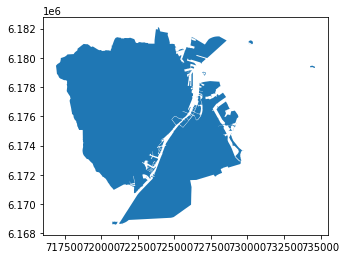

In [9]:
gdf_osm.set_crs(epsg=4326, inplace=True, allow_override=True)
gdf_osm.to_crs(epsg=25832, inplace=True) 
gdf_osm.plot();

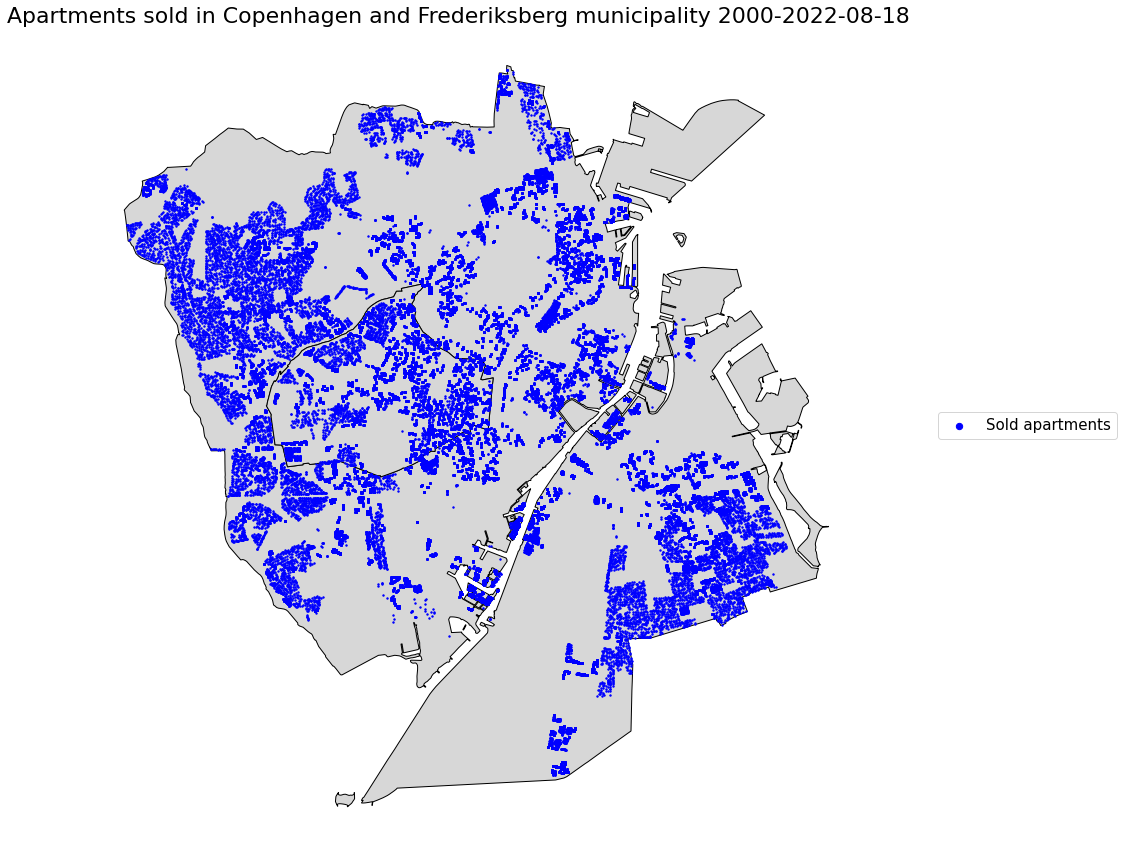

In [10]:
fig, ax = plt.subplots(figsize=(20, 15))

# Copenhagen Area base plot
gdf_osm.plot(color='#d7d7d7',edgecolor='black', ax=ax, label = "Copenhagen Area")

# plot houseprices
geo_houses.plot(ax=ax, color = "blue", markersize=2,  label = "Sold apartments")

# narrow xlim
ax.set_xlim([716000, 730000]) # based on north eastern epsg: 25832
ax.set_axis_off()
ax.set_title(f'Apartments sold in Copenhagen and Frederiksberg municipality {year_from}-{date.today()}', fontsize=22)

# handle legend 
lgnd = fig.legend(loc=7, ncol=1, fontsize = 15)    
lgnd.legendHandles[0]._sizes = [40]


fig.subplots_adjust(right=0.95) 

# Load Spatial Attributes

## 1) Charging Stations (EV)
One of the chosen spatial attributes is charging stations for electric vehicles. We import data from opendata.com on charging stations in the municpality of Copenhagen and Frederiksberg, respectively.

### Charging Stations Frederiksberg

Due to continous update of the id on the [charging station data]( https://www.opendata.dk/city-of-frederiksberg/elbil-ladestandere) provided by municipality of Frederiksberg we have downloaded the GeoJson file and uploaded it to a public github repository from which we fetch the data.

In [11]:
url = 'https://raw.githubusercontent.com/HansChristianPOLIT/geojson_isds2022/main/charging_stations_frederiksberg.geojson'
charging_stations_frb = gpd.read_file(url)

# Inspect data
charging_stations_frb.head() 

,gid,nr_kort,adgangsadresse,beliggenhed_anført,operatoer,ladestandere,ladere,pladser,pladser_uden_delebiler,forbeholdt_elbiler,elbilpladser_ialt,mulige_ekstra_pladser,placering,opladning_pct_af_tid,note,dato_aendret,geometry
0,31,None,Frederiksberg Bredegade 20,P-plads bag Rådhuset,E.ON,1,3,0,2,0,2,0,Offentlig,NaN,Hurtiglader,None,MULTIPOINT (12.52847 55.67885)
1,14,29,Frederiksberg Bredegade 2,Frederiksberg Rådhus Parkeringsplads,Clever,1,2,0,2,0,2,0,Offentlig,NaN,None,2017-11-28T13:18:39,MULTIPOINT (12.52837 55.67886)
2,15,23,Frederiksberg Bredegade 2,Frederiksberg Bredegade 2,E.ON,3,6,1,3,0,4,2,Offentlig,0.13,None,2017-11-28T13:18:39,MULTIPOINT (12.53101 55.67799)
3,18,26,Hovedvejen 7A,"Frederiksberg Hospital, Vej 1",Clever,1,2,0,0,2,2,0,Privat (Frederiksberg Hospital),NaN,None,2017-11-28T13:18:39,MULTIPOINT (12.52447 55.68515)
4,23,18,P.G. Ramms Alle 1,P.G. Ramms Allé 1,E.ON,1,2,1,1,0,2,0,Offentlig,0.18,None,2017-11-28T13:18:39,MULTIPOINT (12.51158 55.67907)


Clean data and keep relevant information:

In [12]:
charging_stations_frb.rename(columns = {'gid':'id', 'adgangsadresse':'address'}, inplace = True) # rename relevant columns to english
charging_stations_frb = charging_stations_frb[['id', 'address','geometry']] # keep only relevant columns
charging_stations_frb.head()

,id,address,geometry
0,31,Frederiksberg Bredegade 20,MULTIPOINT (12.52847 55.67885)
1,14,Frederiksberg Bredegade 2,MULTIPOINT (12.52837 55.67886)
2,15,Frederiksberg Bredegade 2,MULTIPOINT (12.53101 55.67799)
3,18,Hovedvejen 7A,MULTIPOINT (12.52447 55.68515)
4,23,P.G. Ramms Alle 1,MULTIPOINT (12.51158 55.67907)


### Charging Stations Municipality of Copenhagen

We use [data](https://www.opendata.dk/city-of-copenhagen/ladestandere-elbil) from opendata.dk provided by Municipality of Copenhagen.

In [13]:
url = 'https://wfs-kbhkort.kk.dk/k101/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=k101:elbil_ladestander_i_drift&outputFormat=application%2Fjson&srsname=epsg:4326'
charging_stations_cph = gpd.read_file(url)

charging_stations_cph.head() # Inspect data

,id,vejnavn,husnr,betalingszone,tidsbegraensning,ladestandertype,antal_udtag,position,operatoer,faerdigmeldingsdato,faerdigmelding_operatoer,faerdigmelding_smede,bem,status,edoc_sagsnr,reg_dato,opdateret_dato,geometry
0,3,Rådmandsgade,None,Gul takstzone,None,22 kW,2,None,CLEVER A/S,None,None,2020-10-19,None,I drift,2020-0053917,None,None,MULTIPOINT (12.55389 55.70151)
1,626,Brøndkærvej,2,Gul takstzone,None,22 kW,2,None,CLEVER A/S,None,2022-02-24,None,Skiltning er bestilt,I drift,2021-0138513,None,None,MULTIPOINT (12.51782 55.66739)
2,627,Brøndkærvej,2,Gul takstzone,None,22 kW,2,None,CLEVER A/S,None,2022-02-24,None,Skiltning er bestilt,I drift,2021-0138513,None,None,MULTIPOINT (12.51773 55.66742)
3,628,Brøndkærvej,2,Gul takstzone,None,22 kW,2,None,CLEVER A/S,None,2022-02-24,None,Skiltning er bestilt,I drift,2021-0138513,None,None,MULTIPOINT (12.51762 55.66744)
4,629,Brøndkærvej,2,Gul takstzone,None,22 kW,2,None,CLEVER A/S,None,2022-02-24,None,Skiltning er bestilt,I drift,2021-0138513,None,None,MULTIPOINT (12.51753 55.66747)


In [14]:
charging_stations_cph.rename(columns={'vejnavn':'address'}, inplace=True) # rename relevant columns to english
charging_stations_cph = charging_stations_cph[['id', 'address','geometry']]
#charging_stations_cph

### Concatenate
We merge the data to create dataFrame of the total EV charging stations in the Copenhagen Area. 

In [15]:
combine_dfs = [charging_stations_cph, charging_stations_frb]
charging_stations_total = pd.concat(combine_dfs)
charging_stations_total.reset_index(inplace=True, drop=True) # <-- reset index

charging_stations_total # view merged data

,id,address,geometry
0,3,Rådmandsgade,MULTIPOINT (12.55389 55.70151)
1,626,Brøndkærvej,MULTIPOINT (12.51782 55.66739)
2,627,Brøndkærvej,MULTIPOINT (12.51773 55.66742)
3,628,Brøndkærvej,MULTIPOINT (12.51762 55.66744)
4,629,Brøndkærvej,MULTIPOINT (12.51753 55.66747)
...,...,...,...
725,25,Sankt Thomas Alle 19,MULTIPOINT (12.54740 55.67486)
726,26,Solbjerg Plads 3,MULTIPOINT (12.53084 55.68154)
727,27,Steenstrups Alle 13,MULTIPOINT (12.55148 55.68137)
728,28,Thurøvej 3,MULTIPOINT (12.52480 55.68355)


### Extract lattitude and longitude of geometry column

To extract lattitude and longitude we will use `regex`, therefore we import the following package:

In [16]:
# Import packages
import re
import numpy as np

In [17]:
charging_stations_total['geometry_str'] = charging_stations_total['geometry'].astype(str) # convert to str to leverage `re`
charging_stations_total

,id,address,geometry,geometry_str
0,3,Rådmandsgade,MULTIPOINT (12.55389 55.70151),MULTIPOINT (12.55388686349459 55.70150594054824)
1,626,Brøndkærvej,MULTIPOINT (12.51782 55.66739),MULTIPOINT (12.5178184694157 55.66739453477894)
2,627,Brøndkærvej,MULTIPOINT (12.51773 55.66742),MULTIPOINT (12.51772557295722 55.66741876280089)
3,628,Brøndkærvej,MULTIPOINT (12.51762 55.66744),MULTIPOINT (12.51762476304165 55.6674425332664)
4,629,Brøndkærvej,MULTIPOINT (12.51753 55.66747),MULTIPOINT (12.51753002367943 55.66746647174671)
...,...,...,...,...
725,25,Sankt Thomas Alle 19,MULTIPOINT (12.54740 55.67486),MULTIPOINT (12.54740497426069 55.67486113867896)
726,26,Solbjerg Plads 3,MULTIPOINT (12.53084 55.68154),MULTIPOINT (12.53083991033914 55.68154292649228)
727,27,Steenstrups Alle 13,MULTIPOINT (12.55148 55.68137),MULTIPOINT (12.5514752674071 55.68136906282076)
728,28,Thurøvej 3,MULTIPOINT (12.52480 55.68355),MULTIPOINT (12.52480121103149 55.68354750639479)


Thereafter, we find the pattern and create a function to extract the 2 regex *groups* from the geometry_str column:

In [18]:
# define reg pattern
lat_lng_pattern = re.compile(r"\((.*) \s*(.*)\)")

# define function for extraction 
def extract_lng_lat(address):
    """ Takes coordinates as input and search for the longitude and lattitude using regular expression.

        Parameter
        ----------
        arg : coordinates 

        Returns
        -------
        tuple of longitude and lattitude
    """
    try: 
        lng_lat_match = lat_lng_pattern.search(address)
        lng = float(lng_lat_match.group(1))
        lat = float(lng_lat_match.group(2))
        return (lng,lat)
    except:
        return (np.NaN, np.NaN)

Apply the regular expression function on the dataFrame:

In [19]:
lng_lats = [extract_lng_lat(location) for location in charging_stations_total.loc[:,'geometry_str']]
charging_stations_total['lng'] = [lat for lat, lng in lng_lats]
charging_stations_total['lat'] =  [lng for lat, lng in lng_lats]

charging_stations_total = charging_stations_total.drop('geometry_str', axis=1) # drop irrelevant column
charging_stations_total.head() # Inspect result

,id,address,geometry,lng,lat
0,3,Rådmandsgade,MULTIPOINT (12.55389 55.70151),12.553887,55.701506
1,626,Brøndkærvej,MULTIPOINT (12.51782 55.66739),12.517818,55.667395
2,627,Brøndkærvej,MULTIPOINT (12.51773 55.66742),12.517726,55.667419
3,628,Brøndkærvej,MULTIPOINT (12.51762 55.66744),12.517625,55.667443
4,629,Brøndkærvej,MULTIPOINT (12.51753 55.66747),12.517530,55.667466


## 2) Metrostations

We use [data](https://www.opendata.dk/city-of-copenhagen/oversigtskort) on metrostations from opendata.dk provided by Municipality of Copenhagen.

In [20]:
url = 'https://wfs-kbhkort.kk.dk/k101/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=k101:station_oversigtskort&outputFormat=json&SRSNAME=EPSG:4326' 
stations = gpd.read_file(url)

#stations.head(60) # Inspect data

In [21]:
# Fetch only metrostations
metrostations = stations.loc[(stations['objekt_type'] == 'Metrostation')]

# Remove the station in Municpality of Tårnby
metrostations = metrostations[metrostations.kommune != 'Tårnby']

metrostations.rename(columns = {'navn':'address','kommune':'municipality'}, inplace = True)
metrostations.reset_index(drop=True,inplace=True)
metrostations['geometry_str'] = metrostations['geometry'].astype(str) # create new str column for regular expression
metrostations.head() # <-- inspect data

,id,objekt_type,address,municipality,geometry,geometry_str
0,53,Metrostation,Forum,Frederiksberg,MULTIPOINT (12.55250 55.68184),MULTIPOINT (12.55250252831948 55.68183658102229)
1,54,Metrostation,Frederiksberg,Frederiksberg,MULTIPOINT (12.53125 55.68124),MULTIPOINT (12.53125429700097 55.68124300422948)
2,55,Metrostation,Fasanvej (Solbjerg),Frederiksberg,MULTIPOINT (12.52353 55.68162),MULTIPOINT (12.52353141301106 55.68161867111091)
3,56,Metrostation,Lindevang,Frederiksberg,MULTIPOINT (12.51334 55.68339),MULTIPOINT (12.51333703050086 55.68339344818599)
4,57,Metrostation,Flintholm,Frederiksberg,MULTIPOINT (12.49965 55.68592),MULTIPOINT (12.49964645088805 55.68592249094199)


Apply the regular expression function on the metrostations dataFrame:

In [22]:
lng_lats = [extract_lng_lat(location) for location in metrostations.loc[:,'geometry_str']]
metrostations['lng'] = [lat for lat, lng in lng_lats]
metrostations['lat'] =  [lng for lat, lng in lng_lats]

metrostations = metrostations.drop('geometry_str', axis=1) # drop irrelevant column
metrostations.head() # Inspect result

,id,objekt_type,address,municipality,geometry,lng,lat
0,53,Metrostation,Forum,Frederiksberg,MULTIPOINT (12.55250 55.68184),12.552503,55.681837
1,54,Metrostation,Frederiksberg,Frederiksberg,MULTIPOINT (12.53125 55.68124),12.531254,55.681243
2,55,Metrostation,Fasanvej (Solbjerg),Frederiksberg,MULTIPOINT (12.52353 55.68162),12.523531,55.681619
3,56,Metrostation,Lindevang,Frederiksberg,MULTIPOINT (12.51334 55.68339),12.513337,55.683393
4,57,Metrostation,Flintholm,Frederiksberg,MULTIPOINT (12.49965 55.68592),12.499646,55.685922


## 3) Restaurants
In order to select custom features from the OpenStreetMap we use the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API). To query Overpass API in Python we use the wrapper [overpy](https://github.com/DinoTools/python-overpy).

In [23]:
# Import package 
import overpy 
api = overpy.Overpass()

### Restaurants in the Municipality of Frederiksberg

Fetch restaurants in Frederiksberg from OpenStreetMaps:

In [24]:
query_result = api.query("""
area["wikidata" = "Q2488464"]->.place;   
node["amenity"="restaurant"](area.place);
out body;
""") # Q2488464 defines borders of Frederiksberg in OpenStreetMap (OSM)

We convert nodes from OSM into GeoDataFrame:

In [25]:
from shapely.geometry import Point # we need to turn lng & lat into points on globe

points_array = [ Point(x.lon, x.lat) for x in query_result.nodes]
points_series = gpd.GeoSeries(points_array)

restaurant_array = [ { 
    "name": x.tags.get("name", "")
} for x in query_result.nodes]

restaurants_frb = gpd.GeoDataFrame(restaurant_array, geometry=points_series, crs=4326) # save as gdf
restaurants_frb # inspect result 

,name,geometry
0,Viet Nam Nam,POINT (12.53765 55.68564)
1,La Fiesta Mexicana,POINT (12.54523 55.67326)
2,Akropolis,POINT (12.55160 55.68436)
3,Nyu Sakura,POINT (12.55142 55.68410)
4,Allegade 10,POINT (12.53322 55.67600)
...,...,...
71,Koreansk B.B.Q.,POINT (12.50227 55.68460)
72,Bjørnekælderen,POINT (12.53741 55.67403)
73,Circolo,POINT (12.55179 55.67425)
74,Taigoo,POINT (12.53458 55.68156)


### Restaurants in the Municipality of Copenhagen

In [26]:
query_result = api.query("""
area["wikidata" = "Q504125"]->.place;   
node["amenity"="restaurant"](area.place);
out body;
""") # Q504125 defines borders of Municipality of Copenhagen in OpenStreetMap (OSM)

In [27]:
points_array = [ Point(x.lon, x.lat) for x in query_result.nodes]
points_series = gpd.GeoSeries(points_array)

restaurant_array = [ { 
    "name": x.tags.get("name", "")
} for x in query_result.nodes]

restaurants_cph = gpd.GeoDataFrame(restaurant_array, geometry=points_series, crs=4326)
restaurants_cph # inspect result 

,name,geometry
0,Nørrebro Bryghus Restaurant,POINT (12.56391 55.69022)
1,Ingolfs Kaffebar,POINT (12.61197 55.65013)
2,Rio Bravo,POINT (12.57306 55.67425)
3,Sticks'n'Sushi,POINT (12.55471 55.66971)
4,Kafe Kapers,POINT (12.57680 55.70508)
...,...,...
663,The MidWestern Diner,POINT (12.57358 55.68262)
664,Bistro RK,POINT (12.54696 55.69574)
665,Villanelle,POINT (12.57390 55.68977)
666,Restaurant Banzai,POINT (12.55444 55.66878)


#### Concatenate Restaurant Data

In [28]:
combine_restaurants = [restaurants_cph, restaurants_frb]
restaurants_total = pd.concat(combine_restaurants)
restaurants_total.reset_index(inplace=True, drop=True) # <-- reset index
restaurants_total['geometry_str'] = restaurants_total['geometry'].astype(str)
#restaurants_total # inspect data

Apply regular expression function to extract longitude and lattiude:

In [29]:
lng_lats = [extract_lng_lat(location) for location in restaurants_total.loc[:,'geometry_str']]
restaurants_total['lng'] = [lat for lat, lng in lng_lats]
restaurants_total['lat'] =  [lng for lat, lng in lng_lats]
restaurants_total = restaurants_total.drop('geometry_str', axis=1) # remove irrelevant column
restaurants_total.head()

,name,geometry,lng,lat
0,Nørrebro Bryghus Restaurant,POINT (12.56391 55.69022),12.563907,55.690217
1,Ingolfs Kaffebar,POINT (12.61197 55.65013),12.611974,55.650133
2,Rio Bravo,POINT (12.57306 55.67425),12.573063,55.674250
3,Sticks'n'Sushi,POINT (12.55471 55.66971),12.554713,55.669711
4,Kafe Kapers,POINT (12.57680 55.70508),12.576802,55.705084


## 4) Malls 

In the following we make a "workaround" to extract ways and relations from OSM via Overpass API:

In [30]:
# Import packages
import osm2geojson
import requests
import json

### Malls on Frederiksberg

In [31]:
response = requests.get('https://overpass-api.de/api/interpreter?data=[out:xml][timeout:25];(area["wikidata"="Q2488464"]->.place;node["shop"="mall"](area.place);way["shop"="mall"](area.place);relation["shop"="mall"](area.place););out geom;')

string_frb = response.text.replace("\n","")
geojson_malls_frb = osm2geojson.xml2geojson(string_frb) # convert the XML to Geojson using osm2geojson

malls_frb = gpd.GeoDataFrame.from_features(geojson_malls_frb["features"])
malls_frb = malls_frb.drop([0]) # <-- redundant node 
malls_frb.rename(columns = {'tags':'name'}, inplace = True)

malls_frb['name'] = 'Frederiksberg Centret'
malls_frb # view result

,geometry,type,id,name
1,"POLYGON ((12.53124 55.68209, 12.53115 55.68206...",way,25421581,Frederiksberg Centret


Extract lattitude and longitude using an anonymous function:
- note to calculate distances to a polygon we use the center coordinate as reference point, therefore, we apply the method *centroid*.

In [32]:
# extract coordinates
malls_frb["lng"] = malls_frb.centroid.map(lambda p: p.x)
malls_frb["lat"] = malls_frb.centroid.map(lambda p: p.y)

# convert latitude/longtitude columns to Geometry Column using Python using list comprehsion
#malls_frb['geometry_center_point'] = [Point(xy) for xy in zip(malls_frb['lng'], malls_frb['lat'])]

malls_frb.set_crs(epsg=4326, allow_override=True)
malls_frb

,geometry,type,id,name,lng,lat
1,"POLYGON ((12.53124 55.68209, 12.53115 55.68206...",way,25421581,Frederiksberg Centret,12.532397,55.681661


### Malls in Copenhagen

In [34]:
# make a request to overpass and return XML
response = requests.get('https://overpass-api.de/api/interpreter?data=[out:xml][timeout:25];(area["wikidata"="Q504125"]->.place;node["shop"="mall"](area.place);way["shop"="mall"](area.place);relation["shop"="mall"](area.place););out geom;')

string = response.text.replace("\n","")
geojson_malls_cph = osm2geojson.xml2geojson(string) # convert the XML to Geojson using osm2geojson

malls_cph = gpd.GeoDataFrame.from_features(geojson_malls_cph["features"])
malls_cph = malls_cph.drop([6]) # <-- misplaced as mall on OSM
malls_cph.rename(columns = {'tags':'name'}, inplace = True)

newcol = ['Fisketorvet','Fields', 'Nørrebro Bycenter', 'Spinderiet', 'Amager Centret', 'Kronen Vanløse','Illum'] 
malls_cph['name'] = newcol
malls_cph # inspect result

,geometry,type,id,name
0,"POLYGON ((12.56157 55.66271, 12.56167 55.66267...",way,25478561,Fisketorvet
1,"POLYGON ((12.57891 55.62934, 12.57955 55.63103...",way,25520870,Fields
2,"POLYGON ((12.53764 55.70195, 12.53800 55.70192...",way,25523373,Nørrebro Bycenter
3,"POLYGON ((12.51046 55.66442, 12.51037 55.66423...",way,108369191,Spinderiet
4,"POLYGON ((12.60327 55.66332, 12.60365 55.66342...",way,116604434,Amager Centret
5,"POLYGON ((12.59974 55.69554, 12.59988 55.69550...",way,132276129,Kronen Vanløse
7,"MULTIPOLYGON (((12.58114 55.67934, 12.58074 55...",relation,1806193,Illum


In [35]:
malls_cph["lng"] = malls_cph.centroid.map(lambda p: p.x)
malls_cph["lat"] = malls_cph.centroid.map(lambda p: p.y)

#malls_cph['geometry_center_point'] = [Point(xy) for xy in zip(malls_cph['lng'], malls_cph['lat'])]

malls_cph.set_crs(epsg=4326, allow_override=True)
malls_cph # view results

,geometry,type,id,name,lng,lat
0,"POLYGON ((12.56157 55.66271, 12.56167 55.66267...",way,25478561,Fisketorvet,12.561381,55.661924
1,"POLYGON ((12.57891 55.62934, 12.57955 55.63103...",way,25520870,Fields,12.577597,55.630457
2,"POLYGON ((12.53764 55.70195, 12.53800 55.70192...",way,25523373,Nørrebro Bycenter,12.538406,55.703506
3,"POLYGON ((12.51046 55.66442, 12.51037 55.66423...",way,108369191,Spinderiet,12.511518,55.664678
4,"POLYGON ((12.60327 55.66332, 12.60365 55.66342...",way,116604434,Amager Centret,12.604675,55.663095
5,"POLYGON ((12.59974 55.69554, 12.59988 55.69550...",way,132276129,Kronen Vanløse,12.600134,55.696968
7,"MULTIPOLYGON (((12.58114 55.67934, 12.58074 55...",relation,1806193,Illum,12.580262,55.679536


### Concatenate

In [36]:
combine_malls = [malls_cph, malls_frb]
malls_total = pd.concat(combine_malls)
malls_total = malls_total.drop('type', axis=1) # drop irrelevant column
malls_total = malls_total.drop('id', axis=1) # drop irrelevant column
malls_total.reset_index(inplace=True, drop=True) # <-- reset index
malls_total

,geometry,name,lng,lat
0,"POLYGON ((12.56157 55.66271, 12.56167 55.66267...",Fisketorvet,12.561381,55.661924
1,"POLYGON ((12.57891 55.62934, 12.57955 55.63103...",Fields,12.577597,55.630457
2,"POLYGON ((12.53764 55.70195, 12.53800 55.70192...",Nørrebro Bycenter,12.538406,55.703506
3,"POLYGON ((12.51046 55.66442, 12.51037 55.66423...",Spinderiet,12.511518,55.664678
4,"POLYGON ((12.60327 55.66332, 12.60365 55.66342...",Amager Centret,12.604675,55.663095
5,"POLYGON ((12.59974 55.69554, 12.59988 55.69550...",Kronen Vanløse,12.600134,55.696968
6,"MULTIPOLYGON (((12.58114 55.67934, 12.58074 55...",Illum,12.580262,55.679536
7,"POLYGON ((12.53124 55.68209, 12.53115 55.68206...",Frederiksberg Centret,12.532397,55.681661


## 5) Parks
- Again, we use a "workaround" to extract (multi)poylgon geometric data from OSM.

### Park Data on Frederiksberg

In [37]:
response = requests.get('https://overpass-api.de/api/interpreter?data=[out:xml][timeout:25];(area["wikidata" = "Q2488464"]->.place;way["leisure"="park"](area.place););out geom;')

string_frb = response.text.replace("\n","")
geojson_park_frb = osm2geojson.xml2geojson(string_frb)

parks_frb = gpd.GeoDataFrame.from_features(geojson_park_frb["features"])
parks_frb.rename(columns = {'tags':'name'}, inplace = True)
parks_frb # inspect result

,geometry,type,id,name
0,"POLYGON ((12.55356 55.68152, 12.55276 55.68035...",way,25109231,"{'leisure': 'park', 'name': 'Julius Thomsens P..."
1,"POLYGON ((12.54142 55.68183, 12.54082 55.68037...",way,25110138,"{'leisure': 'park', 'name': 'Landbohøjskolens ..."
2,"POLYGON ((12.50990 55.67975, 12.51166 55.67940...",way,25451864,"{'leisure': 'park', 'name': 'Lindevangsparken'..."
3,"POLYGON ((12.50883 55.67869, 12.50906 55.67870...",way,25545930,{'leisure': 'park'}
4,"POLYGON ((12.51962 55.69268, 12.52218 55.69400...",way,26143737,"{'landuse': 'forest', 'leisure': 'park'}"
...,...,...,...,...
333,"POLYGON ((12.50543 55.68200, 12.50545 55.68194...",way,757531403,{'leisure': 'park'}
334,"POLYGON ((12.49273 55.67798, 12.49279 55.67818...",way,846403249,{'leisure': 'park'}
335,"POLYGON ((12.53286 55.68073, 12.53291 55.68100...",way,956136408,"{'leisure': 'park', 'name': 'Bodil Kochs Have'..."
336,"POLYGON ((12.52575 55.68650, 12.52610 55.68641...",way,1056586003,{'leisure': 'park'}


### Park Data on Copenhagen

In [38]:
response = requests.get('https://overpass-api.de/api/interpreter?data=[out:xml][timeout:25];(area["wikidata" = "Q504125"]->.place;way["leisure"="park"](area.place););out geom;')

string_cph = response.text.replace("\n","")
geojson_park_cph = osm2geojson.xml2geojson(string_cph)

parks_cph = gpd.GeoDataFrame.from_features(geojson_park_cph["features"])
parks_cph.rename(columns = {'tags':'name'}, inplace = True)
parks_cph # inspect result

,geometry,type,id,name
0,"POLYGON ((12.56440 55.67980, 12.56478 55.67967...",way,3098756,"{'leisure': 'park', 'name': 'Ørstedsparken', '..."
1,"POLYGON ((12.57118 55.68667, 12.57102 55.68656...",way,3098803,"{'fee': 'no', 'historic': 'yes', 'leisure': 'p..."
2,"POLYGON ((12.54223 55.69320, 12.54198 55.69340...",way,3099108,"{'leisure': 'park', 'name': 'Hørsholmparken'}"
3,"POLYGON ((12.61670 55.65340, 12.61820 55.65366...",way,3107466,"{'leisure': 'park', 'name': 'Filipsparken'}"
4,"POLYGON ((12.56940 55.69220, 12.56797 55.69296...",way,4250637,"{'leisure': 'park', 'name': 'Fredens Park', 'w..."
...,...,...,...,...
581,"POLYGON ((12.58297 55.71936, 12.58312 55.71944...",way,1066179653,{'leisure': 'park'}
582,"POLYGON ((12.56560 55.71074, 12.56562 55.71080...",way,1071262033,{'leisure': 'park'}
583,"POLYGON ((12.57220 55.71597, 12.57219 55.71594...",way,1079838103,{'leisure': 'park'}
584,"POLYGON ((12.58430 55.63822, 12.58427 55.63815...",way,1080251352,{'leisure': 'park'}


### Concatenate

In [39]:
combine_parks = [parks_frb, parks_cph]
parks_total = pd.concat(combine_parks)
parks_total.reset_index(inplace=True, drop=True) # reset index
parks_total

,geometry,type,id,name
0,"POLYGON ((12.55356 55.68152, 12.55276 55.68035...",way,25109231,"{'leisure': 'park', 'name': 'Julius Thomsens P..."
1,"POLYGON ((12.54142 55.68183, 12.54082 55.68037...",way,25110138,"{'leisure': 'park', 'name': 'Landbohøjskolens ..."
2,"POLYGON ((12.50990 55.67975, 12.51166 55.67940...",way,25451864,"{'leisure': 'park', 'name': 'Lindevangsparken'..."
3,"POLYGON ((12.50883 55.67869, 12.50906 55.67870...",way,25545930,{'leisure': 'park'}
4,"POLYGON ((12.51962 55.69268, 12.52218 55.69400...",way,26143737,"{'landuse': 'forest', 'leisure': 'park'}"
...,...,...,...,...
919,"POLYGON ((12.58297 55.71936, 12.58312 55.71944...",way,1066179653,{'leisure': 'park'}
920,"POLYGON ((12.56560 55.71074, 12.56562 55.71080...",way,1071262033,{'leisure': 'park'}
921,"POLYGON ((12.57220 55.71597, 12.57219 55.71594...",way,1079838103,{'leisure': 'park'}
922,"POLYGON ((12.58430 55.63822, 12.58427 55.63815...",way,1080251352,{'leisure': 'park'}


Because a lot of polygons in OSM is defined as parks, we choose to keep only parks that have a name tag:

In [40]:
name_parks = [d.get('name') for d in parks_total.name]
parks_total['name'] = name_parks

parks_total = parks_total[parks_total.name.notnull()] # remove parks with no name tag
parks_total = parks_total[parks_total.name != 'Kastrup Strandpark'] # remove because not park of cph nor frb
parks_total = parks_total[parks_total.name != 'Høje Gladsaxe Park'] # remove because not park of cph nor frb
parks_total = parks_total.drop('type', axis=1) # drop irrelevant column
parks_total = parks_total.drop('id', axis=1) # drop irrelevant column

parks_total.reset_index(drop=True)

,geometry,name
0,"POLYGON ((12.55356 55.68152, 12.55276 55.68035...",Julius Thomsens Plads
1,"POLYGON ((12.54142 55.68183, 12.54082 55.68037...",Landbohøjskolens Have
2,"POLYGON ((12.50990 55.67975, 12.51166 55.67940...",Lindevangsparken
3,"POLYGON ((12.52129 55.66776, 12.52136 55.66769...",Søndermarken
4,"POLYGON ((12.52522 55.67135, 12.52611 55.67131...",Frederiksberg Have
...,...,...
95,"POLYGON ((12.57868 55.62766, 12.57905 55.62764...",Hannemanns Park
96,"POLYGON ((12.53707 55.66732, 12.53740 55.66728...",Vesten for Humlen
97,"POLYGON ((12.55168 55.66992, 12.55160 55.66992...",Saxopark
98,"POLYGON ((12.50297 55.65476, 12.50310 55.65492...",Grønttorvsparken


### Extract Longitude and Lattitude of Parks

In [41]:
parks_total["lng"] = parks_total.centroid.map(lambda p: p.x)
parks_total["lat"] = parks_total.centroid.map(lambda p: p.y)

#parks_total['geometry_center_point'] = [Point(xy) for xy in zip(parks_total['lng'], parks_total['lat'])]
parks_total

,geometry,name,lng,lat
0,"POLYGON ((12.55356 55.68152, 12.55276 55.68035...",Julius Thomsens Plads,12.553358,55.680889
1,"POLYGON ((12.54142 55.68183, 12.54082 55.68037...",Landbohøjskolens Have,12.542238,55.680835
2,"POLYGON ((12.50990 55.67975, 12.51166 55.67940...",Lindevangsparken,12.511469,55.680583
8,"POLYGON ((12.52129 55.66776, 12.52136 55.66769...",Søndermarken,12.524728,55.669161
9,"POLYGON ((12.52522 55.67135, 12.52611 55.67131...",Frederiksberg Have,12.525556,55.675169
...,...,...,...,...
880,"POLYGON ((12.57868 55.62766, 12.57905 55.62764...",Hannemanns Park,12.578770,55.627031
882,"POLYGON ((12.53707 55.66732, 12.53740 55.66728...",Vesten for Humlen,12.537051,55.667121
884,"POLYGON ((12.55168 55.66992, 12.55160 55.66992...",Saxopark,12.551334,55.670799
890,"POLYGON ((12.50297 55.65476, 12.50310 55.65492...",Grønttorvsparken,12.504733,55.654898


## 6) Harbor Baths
- The purpose of this automation tool is to extract addresses, lattitudes, and longitudes on "harbor baths" in Copehangen

In [42]:
# Import packages
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

In [43]:
url = 'https://www.visitcopenhagen.dk/koebenhavn/aktiviteter/havnebade-og-strande'
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.implicitly_wait(40) #Waits maximum 100 seconds for an element to be found in the HTML.
driver.get(url)

# We need to click away the popup box with cookie information
driver.find_element(By.CSS_SELECTOR, ".coi-banner__accept").click()

/Users/hanschristian/opt/anaconda3/envs/geoproject/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  


In [51]:
index_list=[1,2,3,4,5,6,8,9,10,11,13]

# Intialize lists
places_list = []
coordinates_list = []

In [52]:
for i in index_list:
    # Locate Specific Information we are Scraping 
    driver.find_element(By.XPATH, f'//div[{i}]/div/div/div/div/div/div/a[@class="GuideItemUi__MoreInfo-im3577-9 goOBMS link-internal"]').click()
    places = driver.find_element(By.XPATH, '//h1[@class="Product__Title-sc-127atq4-13 iuYfEn"]').text
    places_list.append(places)

    coord_btn = driver.find_element(By.XPATH, "//button[contains(text(), 'Koordinater')]").click()

    coordinates = driver.find_element(By.XPATH, '//div[@class="Coordinates__Wrapper-pk556h-0 bdffic panel-info-wrap"]').text
    coordinates_list.append(coordinates)

    #back to previous page with back()
    driver.back()

In [53]:
# convert lists to a dictionary
dict_harbor_baths = dict(zip(places_list, coordinates_list))
print(dict_harbor_baths)

{'Havnebadet Islands Brygge': 'Longitude: 12.5792435\nLatitude: 55.6686857', 'Sandkaj Badezone': 'Longitude: 12.59629719\nLatitude: 55.70658106', 'Havnebadet Sluseholmen': 'Longitude: 12.5523947\nLatitude: 55.6464119', 'Kalvebod Bølge': 'Longitude: 12.574119208\nLatitude: 55.669590738', 'Havnebadet Fisketorvet': 'Longitude: 12.563884251\nLatitude: 55.662524467', 'La Banchina': 'Longitude: 12.61094713\nLatitude: 55.68926854', 'Havnevigen Havnebad': 'Longitude: 12.56698328\nLatitude: 55.65448474', 'Halvandet': 'Longitude: 12.6094398\nLatitude: 55.6957576', 'Søndre Refshalebassin Havnebad': 'Longitude: 12.61014744\nLatitude: 55.68988245', 'Amager Helgoland': 'Longitude: 12.640045637\nLatitude: 55.663725264', 'Svanemøllestranden': 'Longitude: 12.582886599\nLatitude: 55.7192675'}


### Data Cleaning

In [54]:
# convert dictionary to dataFrame
harbor_baths = pd.DataFrame.from_dict(dict_harbor_baths, orient='index')
harbor_baths.rename( columns={0 :'geometry'}, inplace=True )

harbor_baths['address']=harbor_baths.index
harbor_baths.reset_index(drop=True) 

,geometry,address
0,Longitude: 12.5792435\nLatitude: 55.6686857,Havnebadet Islands Brygge
1,Longitude: 12.59629719\nLatitude: 55.70658106,Sandkaj Badezone
2,Longitude: 12.5523947\nLatitude: 55.6464119,Havnebadet Sluseholmen
3,Longitude: 12.574119208\nLatitude: 55.669590738,Kalvebod Bølge
4,Longitude: 12.563884251\nLatitude: 55.662524467,Havnebadet Fisketorvet
5,Longitude: 12.61094713\nLatitude: 55.68926854,La Banchina
6,Longitude: 12.56698328\nLatitude: 55.65448474,Havnevigen Havnebad
7,Longitude: 12.6094398\nLatitude: 55.6957576,Halvandet
8,Longitude: 12.61014744\nLatitude: 55.68988245,Søndre Refshalebassin Havnebad
9,Longitude: 12.640045637\nLatitude: 55.663725264,Amager Helgoland


Extract Lattitudes and Longitudes:

In [55]:
# define reg pattern
lat_lng_pattern = re.compile(r"((\d{1,3},\d{3}(,\d{3})*)(\.\d*)?|\d+\.?\d*)")

# redefine function for extraction 
def extract_lng_lat(address):
    try: 
        lng_lat_match = lat_lng_pattern.search(address)
        lng = float(lng_lat_match.group(0)) # <-- changed 
        lat = float(lng_lat_match.group(0))
        return (lng,lat)
    except:
        return (np.NaN, np.NaN)

In [56]:
# create str column for extraction of lat and lng
harbor_baths['geometry_str'] = harbor_baths['geometry'].astype(str) 

# apply function from earlier
lng_lats = [extract_lng_lat(location) for location in harbor_baths.loc[:,'geometry_str']]
harbor_baths['lng'] = [lat for lat, lng in lng_lats]

#harbor_baths.head() 

In [57]:
# reuse reg pattern
lat_lng_pattern = re.compile(r"[0-9]*\.[0-9]+")
harbor_baths['geometry_str'] = harbor_baths['geometry_str'].str[25:] # ensures lattitude is matched

# apply function from earlier
lng_lats = [extract_lng_lat(location) for location in harbor_baths.loc[:,'geometry_str']]
harbor_baths['lat'] =  [lng for lat, lng in lng_lats]

harbor_baths = harbor_baths.drop('geometry_str', axis=1) # drop irrelevant column
harbor_baths = harbor_baths.drop('geometry', axis=1) # drop irrelevant column
harbor_baths.reset_index(drop=True, inplace=True) 
harbor_baths.head() # inspect data

,address,lng,lat
0,Havnebadet Islands Brygge,12.579244,55.668686
1,Sandkaj Badezone,12.596297,55.706581
2,Havnebadet Sluseholmen,12.552395,55.646412
3,Kalvebod Bølge,12.574119,55.669591
4,Havnebadet Fisketorvet,12.563884,55.662524


# Change Projections of Spatial Attributes to Calculate Distances

To calculate correct distances, we need to specify the correct projection:

In [58]:
# make a GeoDataFrame of charging station data
gdf_charging_stations_total = gpd.GeoDataFrame(
    charging_stations_total, geometry=gpd.points_from_xy(charging_stations_total.lng, charging_stations_total.lat), crs = {'init': 'epsg:4326'})
gdf_charging_stations_total.to_crs(epsg=25832, inplace=True) # <-- to eastern northing

# make a GeoDataFrame of metrostation data
gdf_metrostations = gpd.GeoDataFrame(
    metrostations, geometry=gpd.points_from_xy(metrostations.lng, metrostations.lat), crs = {'init': 'epsg:4326'})
gdf_metrostations.to_crs(epsg=25832, inplace=True)    # change projection to eastern northing

# make a GeoDataFrame of restaurant data
gdf_restaurants_total = gpd.GeoDataFrame(
    restaurants_total, geometry=gpd.points_from_xy(restaurants_total.lng, restaurants_total.lat), crs = {'init': 'epsg:4326'})
gdf_restaurants_total.to_crs(epsg=25832, inplace=True) # <-- to eastern northing

# make a GeoDataFrame of mall data
gdf_malls_total = gpd.GeoDataFrame(
    malls_total, geometry=gpd.points_from_xy(malls_total.lng, malls_total.lat), crs = {'init': 'epsg:4326'})
gdf_malls_total.to_crs(epsg=25832, inplace=True) # <-- to eastern northing

# make a GeoDataFrame of park data
gdf_parks_total = gpd.GeoDataFrame(
    parks_total, geometry=gpd.points_from_xy(parks_total.lng, parks_total.lat), crs = {'init': 'epsg:4326'})
gdf_parks_total.to_crs(epsg=25832, inplace=True) # <-- to eastern northing

# make a GeoDataFrame of harbor bath data
gdf_harbor_baths = gpd.GeoDataFrame(
    harbor_baths, geometry=gpd.points_from_xy(harbor_baths.lng, harbor_baths.lat), crs = {'init': 'epsg:4326'})
gdf_harbor_baths.to_crs(epsg=25832, inplace=True) # <-- to eastern northing

/Users/hanschristian/opt/anaconda3/envs/geoproject/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/hanschristian/opt/anaconda3/envs/geoproject/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/hanschristian/opt/anaconda3/envs/geoproject/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' synt

# Plotting Spatial Attributes

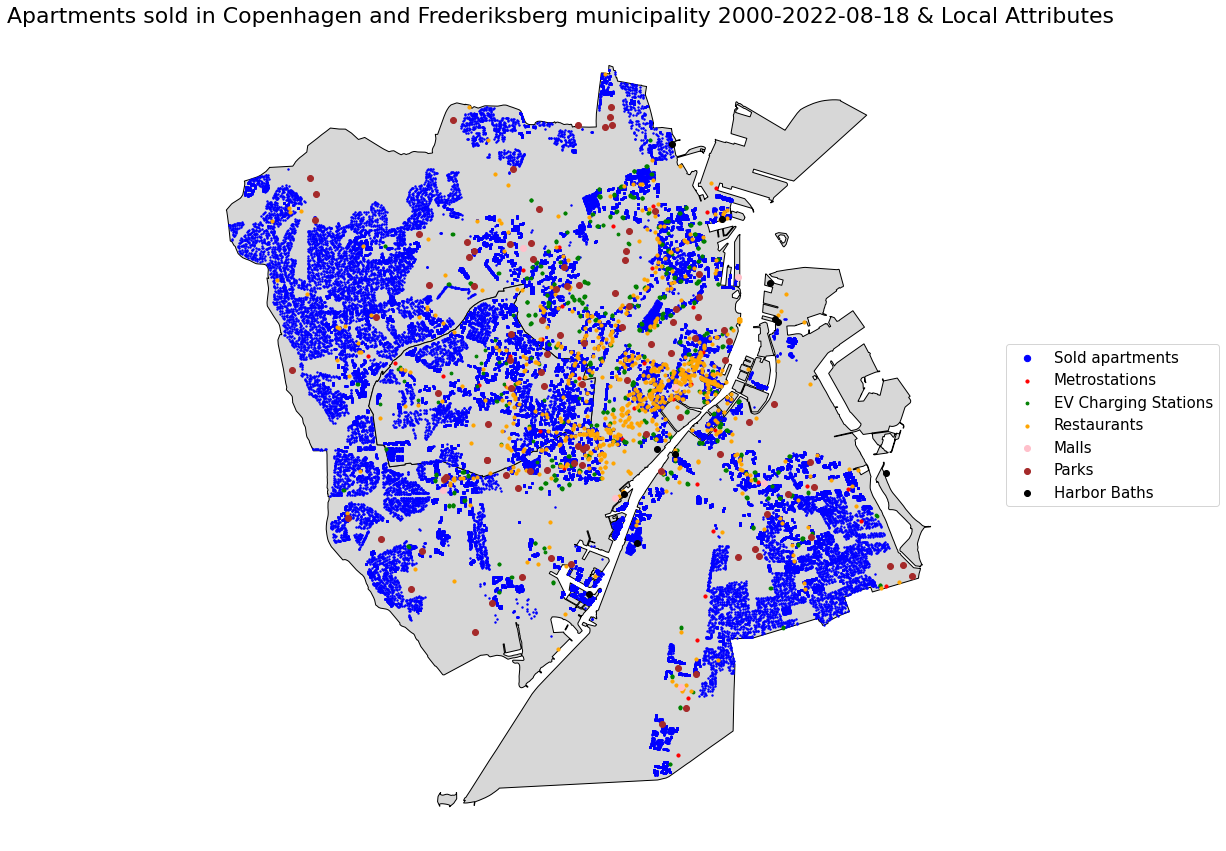

In [59]:
fig, ax = plt.subplots(figsize=(20, 15))

# basemap of Copenhagen Area
gdf_osm.plot(color='#d7d7d7',edgecolor='black', ax=ax, label = "Copenhagen Area")

# plot houseprices
geo_houses.plot(ax=ax, color = "blue", markersize=2,  label = "Sold apartments")

# plot metrostations
metrostations.plot(ax=ax, color = "red", markersize=10,  label = "Metrostations")

# plot charging stations
charging_stations_total.plot(ax=ax, color = "green", markersize=8,  label = "EV Charging Stations")

# plot restaurants
restaurants_total.plot(ax=ax, color = "orange", markersize=10,  label = "Restaurants")

# plot malls
malls_total.plot(ax=ax, color = "pink",  label = "Malls")

# plot parks
parks_total.plot(ax=ax, color = "brown",  label = "Parks")

# plot harbor baths
gdf_harbor_baths.plot(ax=ax, color = "black",  label = "Harbor Baths")

# narrow xlim
ax.set_xlim([716000, 730000])
ax.set_axis_off()
ax.set_title(f'Apartments sold in Copenhagen and Frederiksberg municipality {year_from}-{date.today()} & Local Attributes', fontsize=22)

# handle legend 
lgnd = fig.legend(loc=7, ncol=1, fontsize = 15)    
lgnd.legendHandles[0]._sizes = [40]


fig.subplots_adjust(right=0.95)

In [80]:
# Read in the zip code GeoJson file from Github and look at the first few rows.
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/postnumre.geojson" 
zip_code = gpd.read_file(url)

# Use correct coordinate reference system
#zipcode.to_crs(epsg=25832, inplace=True) 

# inspect data
zip_code.head()

,POSTNR_TXT,POSTBYNAVN,geometry
0,2800,Kongens Lyngby,"POLYGON Z ((12.50455 55.80083 -999.00000, 12.5..."
1,6310,Broager,"POLYGON Z ((9.70544 54.90168 -999.00000, 9.702..."
2,4941,Bandholm,"POLYGON Z ((11.42392 54.84050 -999.00000, 11.4..."
3,5985,Søby Ærø,"POLYGON Z ((10.27247 54.90163 -999.00000, 10.2..."
4,7770,Vestervig,"POLYGON Z ((8.30876 56.72704 -999.00000, 8.308..."


In [81]:
# Fetch zip codes the for municipalities of Copenhagen and Frederiksberg
cph_list = ['København K', 'København Ø', 'København V', 'København SV', 'København NV', 'København N', 'København S', 'Vanløse', 'Brønshøj', 'Valby', 'Frederiksberg', 'Frederiksberg C'] 
zip_code = zip_code.loc[zip_code['POSTBYNAVN'].isin(cph_list)]

In [82]:
zip_code.set_crs(epsg=4326, inplace=True, allow_override=True)
zip_code.to_crs(epsg=25832, inplace=True) 

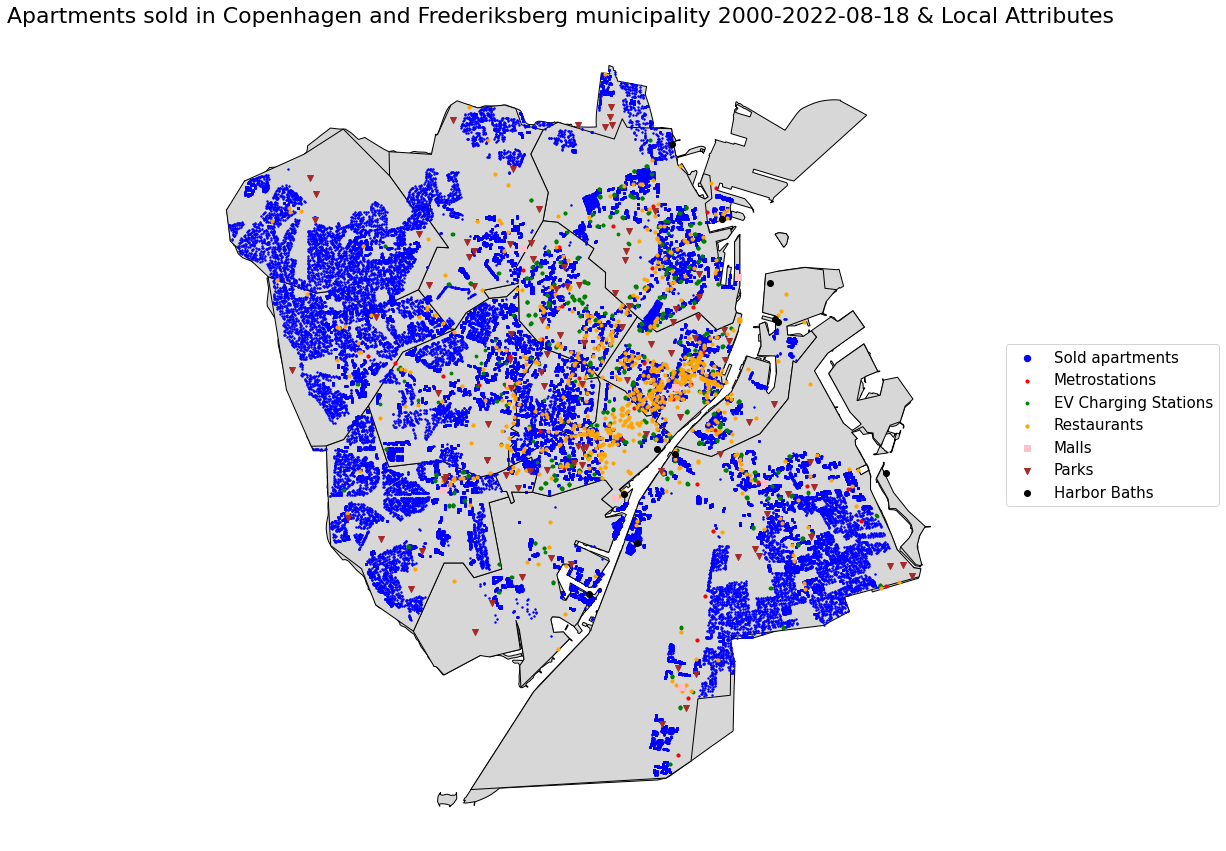

In [136]:
fig, ax = plt.subplots(figsize=(20, 15))

# basemap of Copenhagen Area
gdf_osm.plot(color='#d7d7d7',edgecolor='black', ax=ax, label = "Copenhagen Area")

zip_code.plot(color='#d7d7d7',edgecolor='black', ax=ax)

# plot houseprices
geo_houses.plot(ax=ax, color = "blue",  markersize=2, label = "Sold apartments")
#geo_houses.plot(ax=ax, alpha = .1)

# plot metrostations
metrostations.plot(ax=ax, color = "red", markersize=10,  label = "Metrostations")

# plot charging stations
charging_stations_total.plot(ax=ax, color = "green", markersize=8,  label = "EV Charging Stations")

# plot restaurants
restaurants_total.plot(ax=ax, color = "orange", markersize=10,  label = "Restaurants")

# plot malls
malls_total.plot(ax=ax,marker="s", color = "pink",  label = "Malls")

# plot parks
parks_total.plot(ax=ax, marker="v", color = "brown",  label = "Parks")

# plot harbor baths
gdf_harbor_baths.plot(ax=ax, color = "black",  label = "Harbor Baths")

# narrow xlim
ax.set_xlim([716000, 730000])
ax.set_axis_off()
ax.set_title(f'Apartments sold in Copenhagen and Frederiksberg municipality {year_from}-{date.today()} & Local Attributes', fontsize=22)

# handle legend 
lgnd = fig.legend(loc=7, ncol=1, fontsize = 15)    
lgnd.legendHandles[0]._sizes = [40]


fig.subplots_adjust(right=0.95)

# Calculate Distances

To utilize vectorization of the search of nearest distance we use `scipy`'s `cKDTree spatial index` `.query` method instead of looping through all spatial attributes and finding the one with nearest distance.

In [60]:
# Import packages 
from scipy.spatial import cKDTree
from shapely.geometry import Point

**Define function:**

In [61]:
def ckdnearest(gdfA, gdfB):
    """ Takes geopandasdataframe as input and find the nearest distance between the two for each row.

        Parameter
        ----------
        arg1 : GeoDataFrame_1
        arg2 : GeoDataFrame_2

        Returns
        -------
        GeoDataFrame
    """
    nA = np.array(list(gdfA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdfB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdfB_nearest = gdfB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdfA.reset_index(drop=True),
            gdfB_nearest,
            pd.Series(dist, name='nearest_dist')
        ], 
        axis=1)

    return gdf

In [62]:
nearest_charging_station = ckdnearest(geo_houses, gdf_charging_stations_total)
nearest_metrostation = ckdnearest(geo_houses, gdf_metrostations)
nearest_restaurant = ckdnearest(geo_houses, gdf_restaurants_total)
nearest_mall = ckdnearest(geo_houses, gdf_malls_total)
nearest_park = ckdnearest(geo_houses, gdf_parks_total)
nearest_harbor_bath = ckdnearest(geo_houses, gdf_harbor_baths)

In [63]:
# keep relevant columns & rename
nearest_charging_station = nearest_charging_station.iloc[:,-4:]
nearest_charging_station.rename(columns={'nearest_dist':'nearest_dist_charging_station'}, inplace = True) 

nearest_metrostation = nearest_metrostation.iloc[:,-5:]
nearest_metrostation.rename(columns={'nearest_dist':'nearest_dist_metrostation'}, inplace = True) 

nearest_restaurant = nearest_restaurant.iloc[:,-4:]
nearest_restaurant.rename(columns={'nearest_dist':'nearest_dist_restaurant'}, inplace = True) 

nearest_mall = nearest_mall.iloc[:,-4:]
nearest_mall.rename(columns={'nearest_dist':'nearest_dist_mall'}, inplace = True) 

nearest_park = nearest_park.iloc[:,-4:]
nearest_park.rename(columns={'nearest_dist':'nearest_dist_park'}, inplace = True) 

nearest_harbor_bath = nearest_harbor_bath.iloc[:,-4:]
nearest_harbor_bath.rename(columns={'nearest_dist':'nearest_dist_bath'}, inplace = True) 

In [70]:
geo_houses.reset_index(level=0, inplace=True) # reset index to allow merge

pd1 = pd.merge(geo_houses, nearest_charging_station, left_index=True, right_index=True)
pd2 = pd.merge(pd1, nearest_metrostation, left_index=True, right_index=True)
pd3 = pd.merge(pd2, nearest_restaurant, left_index=True, right_index=True)
pd4 = pd.merge(pd3, nearest_mall, left_index=True, right_index=True)
pd5 = pd.merge(pd4, nearest_park, left_index=True, right_index=True)
merged_geo_houses = pd.merge(pd5, nearest_harbor_bath, left_index=True, right_index=True)
merged_geo_houses

/Users/hanschristian/opt/anaconda3/envs/geoproject/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'lng_x', 'lat_x'} in the result is deprecated and will raise a MergeError in a future version.
  after removing the cwd from sys.path.
/Users/hanschristian/opt/anaconda3/envs/geoproject/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'lng_x', 'lat_x', 'address_x'} in the result is deprecated and will raise a MergeError in a future version.
  


,soldDate,address_x,zipCode,price,propertyType,saleType,sqmPrice,rooms,size,buildYear,...,lat_y,nearest_dist_mall,name,lng_x,lat_x,nearest_dist_park,address_y,lng_y,lat_y,nearest_dist_bath
0,2022-07-27,"Gyldenlakvej 27, 1. tv",2300,2340000,3,Alm. Salg,41052.633,2.0,57,1938,...,55.663095,2066.362925,Sundbyvesterparken,12.601987,55.651210,964.097547,Amager Helgoland,12.640046,55.663725,2685.620041
1,2022-07-27,"Gammel Kongevej 165A, 1",1850,5995000,3,Alm. Salg,66611.110,3.0,90,2000,...,55.681661,483.609416,Bodil Kochs Have,12.532741,55.680872,395.009438,Havnebadet Fisketorvet,12.563884,55.662524,2456.851937
2,2022-07-27,"Rolfsvej 37, 2. th",2000,7887000,3,Alm. Salg,71054.055,4.0,111,1916,...,55.681661,256.295912,Aksel Møllers Have,12.532850,55.685353,171.126588,Kalvebod Bølge,12.574119,55.669591,3105.704917
3,2022-07-26,"Havneholmen 82, 2. th",1561,5200000,3,Alm. Salg,68421.055,2.0,76,2008,...,55.661924,195.014962,Havneparken,12.574878,55.665904,866.732447,Havnebadet Fisketorvet,12.563884,55.662524,162.466248
4,2022-07-22,"Islands Brygge 24B, 4. tv",2300,7825000,3,Alm. Salg,74523.810,3.0,105,1910,...,55.661924,633.392198,Havneparken,12.574878,55.665904,385.629688,Havnebadet Fisketorvet,12.563884,55.662524,466.328877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88782,2000-01-02,"Lykkesholms Allé 10, 2. th",1902,1850000,3,Alm. Salg,22289.156,4.0,83,1876,...,55.681661,1139.139972,Julius Thomsens Plads,12.553358,55.680889,574.489630,Kalvebod Bølge,12.574119,55.669591,1811.887608
88783,2000-01-02,"Lykkesholms Allé 10, 1",1902,1850000,3,Alm. Salg,14015.151,4.0,132,1876,...,55.681661,1139.139972,Julius Thomsens Plads,12.553358,55.680889,574.489630,Kalvebod Bølge,12.574119,55.669591,1811.887608
88784,2000-01-02,"Lykkesholms Allé 10, 2. tv",1902,1850000,3,Alm. Salg,108823.530,1.0,17,1876,...,55.681661,1139.139972,Julius Thomsens Plads,12.553358,55.680889,574.489630,Kalvebod Bølge,12.574119,55.669591,1811.887608
88785,2000-01-02,"Rosenvængets Hovedvej 34, 2. th",2100,1300000,3,Alm. Salg,14130.435,3.0,92,1938,...,55.696968,973.139729,Classens Have,12.588914,55.697816,416.017863,Sandkaj Badezone,12.596297,55.706581,837.421385
